### 라이브러리 install

In [1]:
!pip3 install scikit-learn tqdm catboost optuna ipywidgets imblearn

### 라이브러리 import

In [2]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


### seed 고정

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

### 데이터 불러오기

In [4]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

### 전처리(Data leakage 없음)

In [5]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')

    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

### stratified K-fold(k = 10)

In [6]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

### parameter(cpu)

In [7]:
best_param = {'iterations': 27614,
 'learning_rate': 0.3509403351095515,
 'reg_lambda': 100,
 'random_strength': 65.20460185599707,
 'min_data_in_leaf': 47,
 'leaf_estimation_iterations': 10,
 'bagging_temperature': 0.22622563145185848}

### Train Catboost Classifier(cpu)

In [8]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                    task_type='CPU',
                                verbose=100,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

0:	learn: 0.3128484	test: 0.2176232	best: 0.2176232 (0)	total: 123ms	remaining: 56m 29s
100:	learn: 0.9508131	test: 0.9486371	best: 0.9518415 (61)	total: 2.95s	remaining: 13m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.951841536
bestIteration = 61

Shrink model to first 62 iterations.
0:	learn: 0.3051422	test: 0.2936397	best: 0.2936397 (0)	total: 34.6ms	remaining: 15m 54s
100:	learn: 0.9519023	test: 0.9526572	best: 0.9528427 (95)	total: 2.77s	remaining: 12m 35s
200:	learn: 0.9605712	test: 0.9550631	best: 0.9550631 (193)	total: 5.87s	remaining: 13m 20s
300:	learn: 0.9661685	test: 0.9501937	best: 0.9555303 (206)	total: 9.18s	remaining: 13m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9555302573
bestIteration = 206

Shrink model to first 207 iterations.
0:	learn: 0.3098878	test: 0.2937805	best: 0.2937805 (0)	total: 36.7ms	remaining: 16m 53s
100:	learn: 0.9508572	test: 0.9553736	best: 0.9553736 (100)	total: 3.05s	remaining: 13m 50s
2

### test

In [9]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


### predict(soft voting)

In [10]:
# 예측 수행 (soft voting)
pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(pred, axis=0)
cpu_pred = np.argmax(pred, axis=1)


In [11]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4605    15]
 [  941 50219]]

정확도: 0.9829
정밀도: 0.8303
재현율: 0.9968
F1: 0.9060


In [12]:
for i in range(10):
    best_models[i].save_model(f'model_cpu_{i}.cbm',format='cbm')

### parameter(GPU)

In [13]:
best_param = {'iterations': 22865,
 'learning_rate': 0.4558039595854515,
 'reg_lambda': 40.615274454632356,
 'random_strength': 69.76295482198546,
 'min_data_in_leaf': 18,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.06021831198300387}

### train Catboost Classifier(GPU)

In [14]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                verbose=100,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

0:	learn: 0.8488005	test: 0.8740407	best: 0.8740407 (0)	total: 76.3ms	remaining: 29m 4s
100:	learn: 0.9675047	test: 0.9462738	best: 0.9503950 (55)	total: 1.35s	remaining: 5m 3s
bestTest = 0.9503949918
bestIteration = 55
Shrink model to first 56 iterations.
0:	learn: 0.8449107	test: 0.8647363	best: 0.8647363 (0)	total: 13.9ms	remaining: 5m 16s
100:	learn: 0.9657498	test: 0.9530446	best: 0.9550414 (95)	total: 1.24s	remaining: 4m 40s
bestTest = 0.9550413732
bestIteration = 95
Shrink model to first 96 iterations.
0:	learn: 0.8311139	test: 0.8406697	best: 0.8406697 (0)	total: 15ms	remaining: 5m 42s
100:	learn: 0.9644818	test: 0.9532623	best: 0.9572278 (70)	total: 1.29s	remaining: 4m 50s
bestTest = 0.9572277754
bestIteration = 70
Shrink model to first 71 iterations.
0:	learn: 0.8485508	test: 0.8681493	best: 0.8681493 (0)	total: 14.8ms	remaining: 5m 38s
100:	learn: 0.9671210	test: 0.9377678	best: 0.9438634 (55)	total: 1.27s	remaining: 4m 45s
bestTest = 0.9438633994
bestIteration = 55
Shrink m

### predict(soft voting)

In [15]:
import copy
tmp = copy.deepcopy(best_models)

In [16]:
for i in range(10):
    tmp[i].save_model(f'model_{i}.cbm',format='cbm')

In [17]:
best_models=[]
for i in range(10):
    best_models.append(CatBoostClassifier().load_model(f'model_{i}.cbm', format='cbm'))

In [18]:
# 예측 수행 (soft voting)
pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(pred, axis=0)
gpu_pred = np.argmax(pred, axis=1)

### hard voting(cpu pred + gpu pred)

In [19]:
hard_pred = [True if (cpu_pred[i] or gpu_pred[i]) else False for i in range(len(cpu_pred))]   

In [20]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = hard_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

cpu학습은 seed를 고정시키면 동일한 결과가 나오지만 gpu학습은 seed를 고정시키더라도 결과가 조금씩 틀려 public score기준 0.001미만의 score 차이가 발생할 수 있습니다.(오히려 score가 오를 수 있음)

In [21]:
sum(hard_pred)

1957

In [22]:
sum(cpu_pred)

1900

In [23]:
sum(gpu_pred)

1772

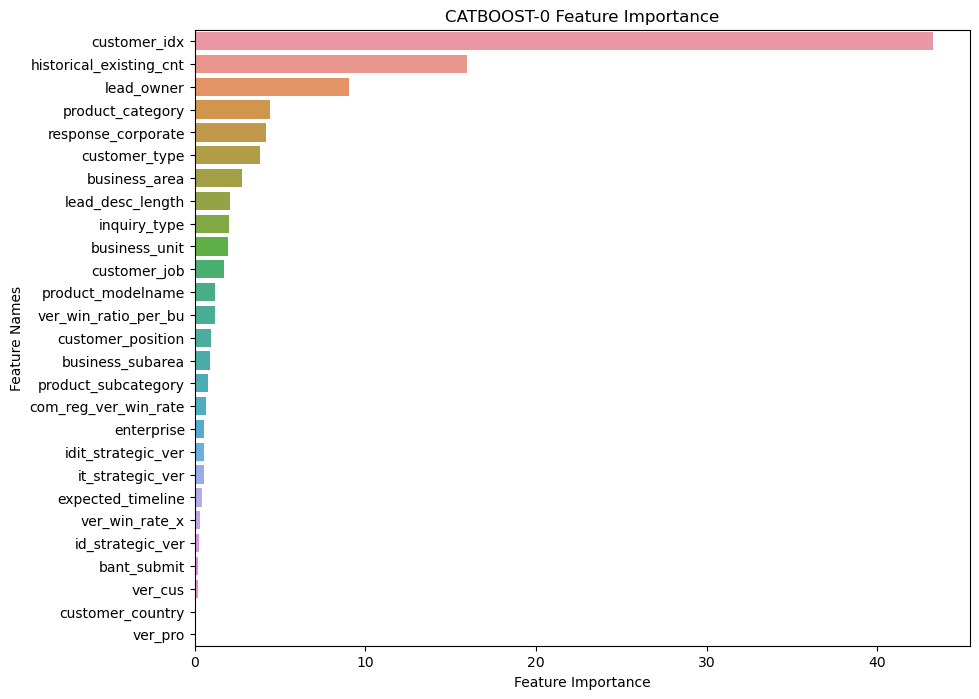

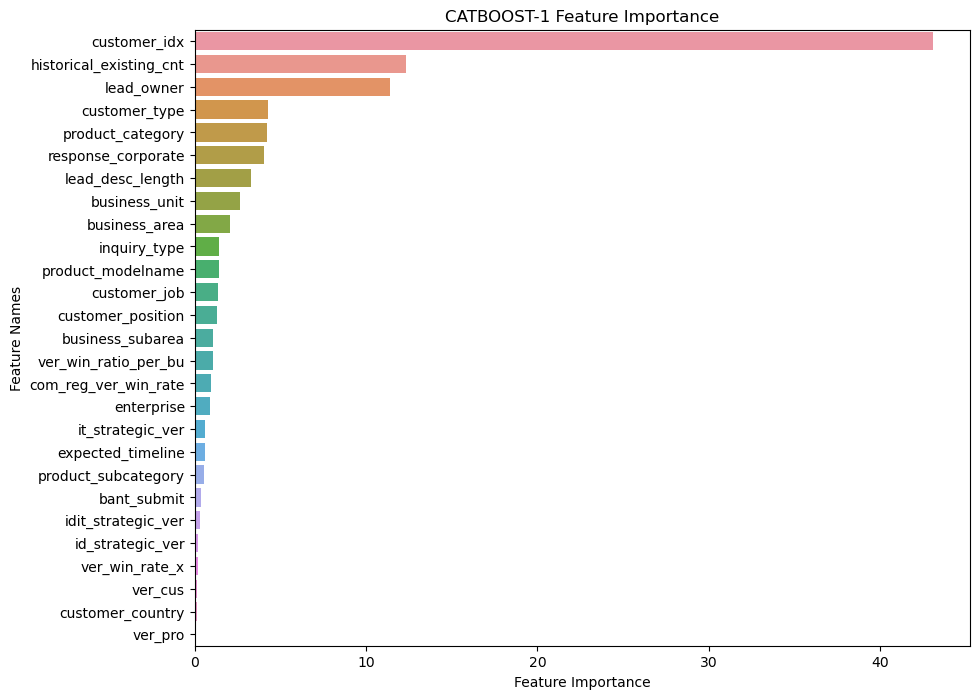

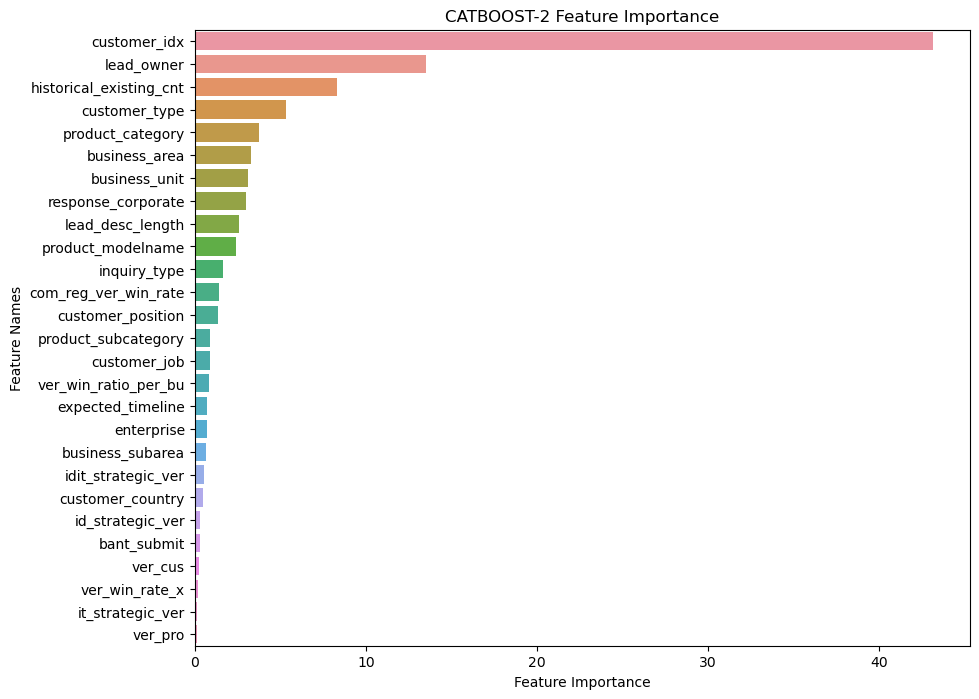

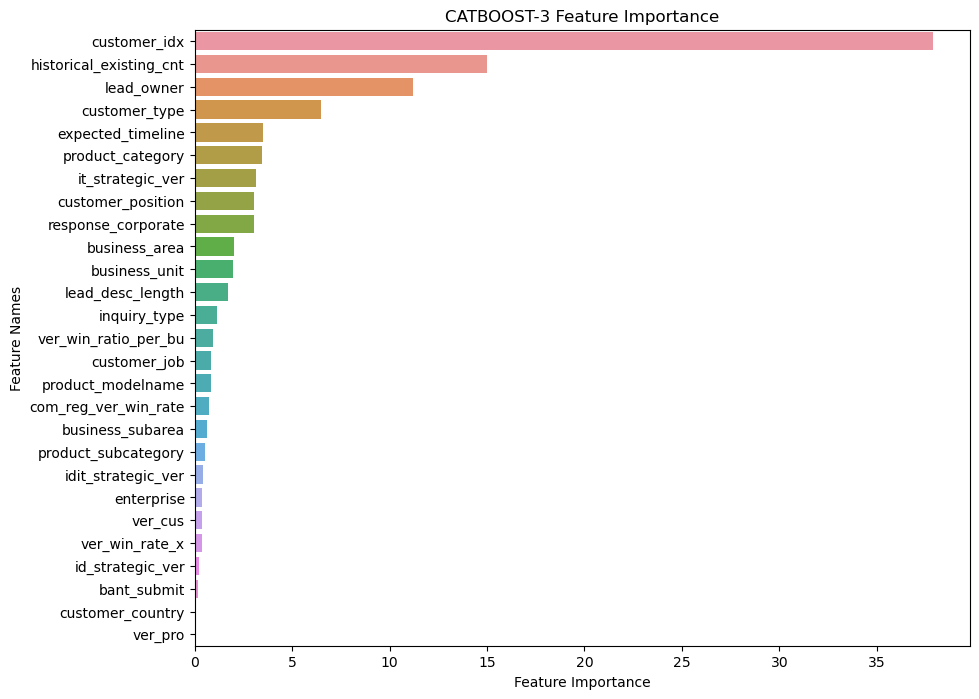

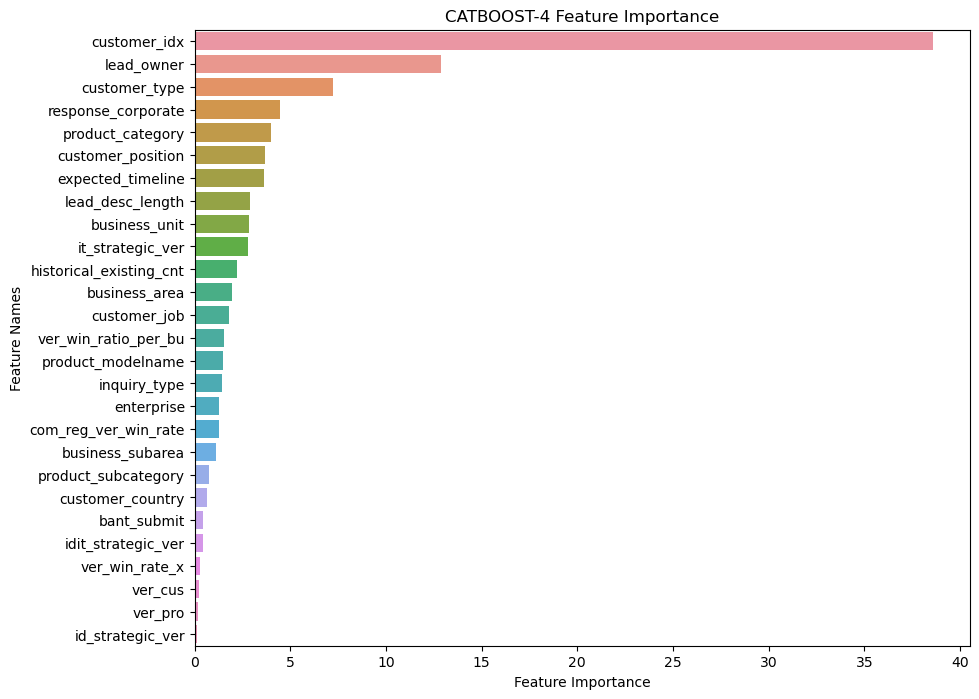

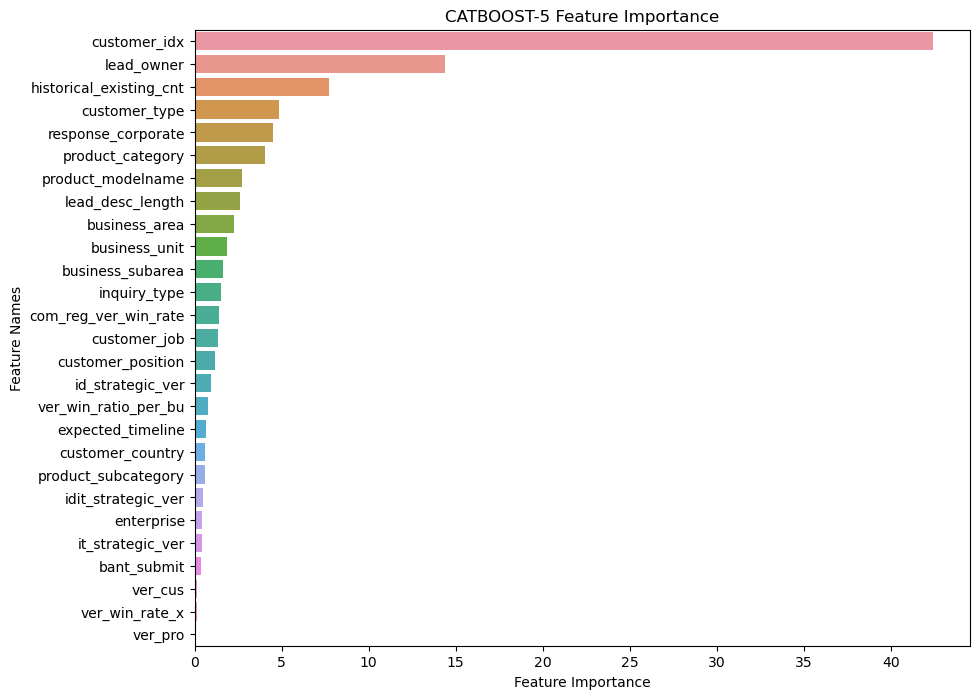

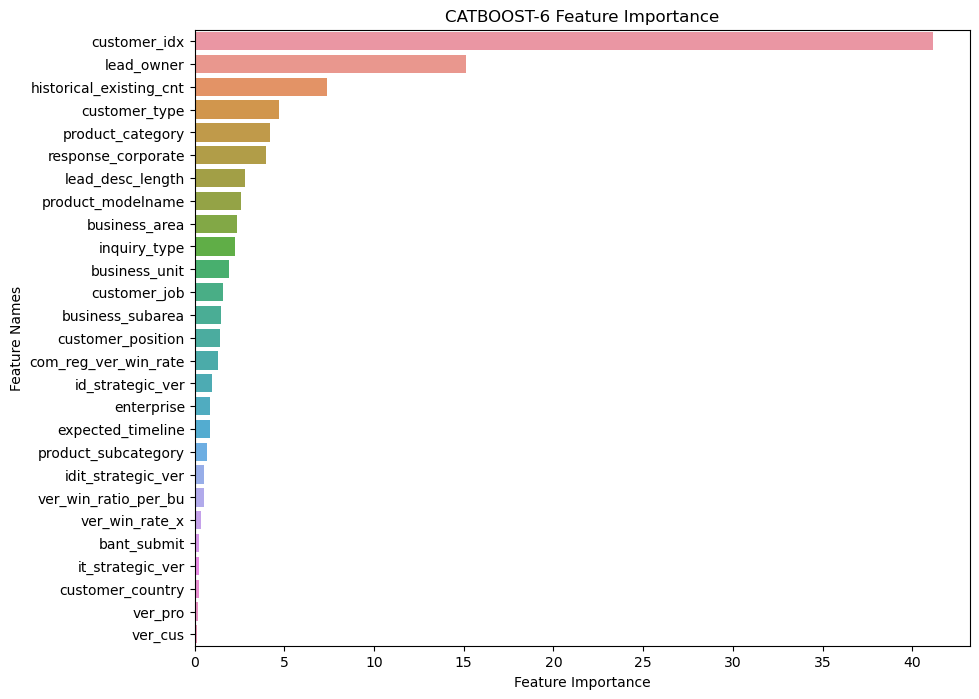

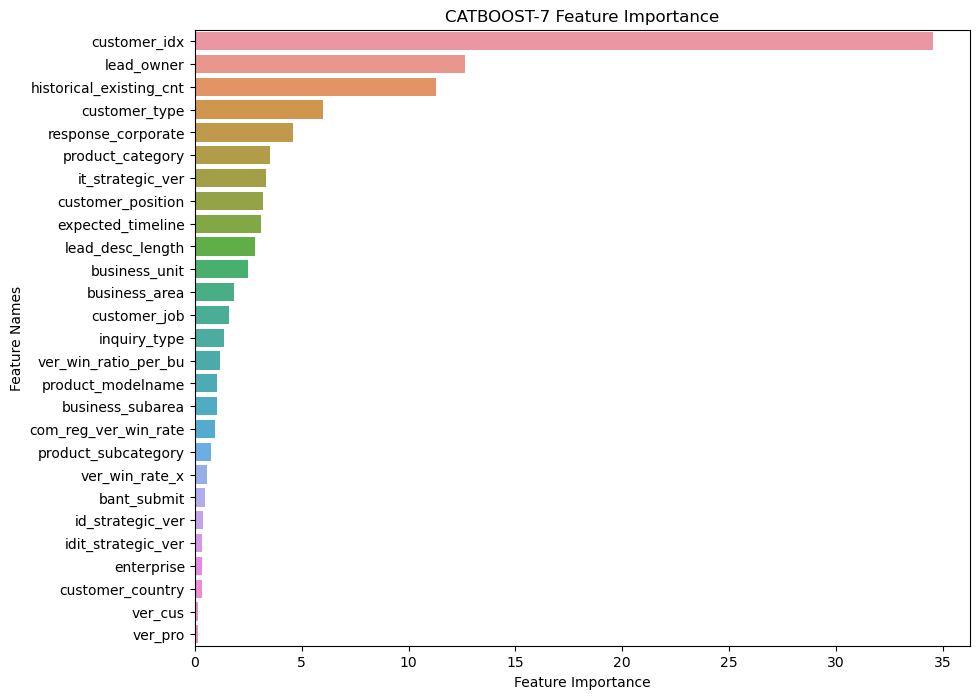

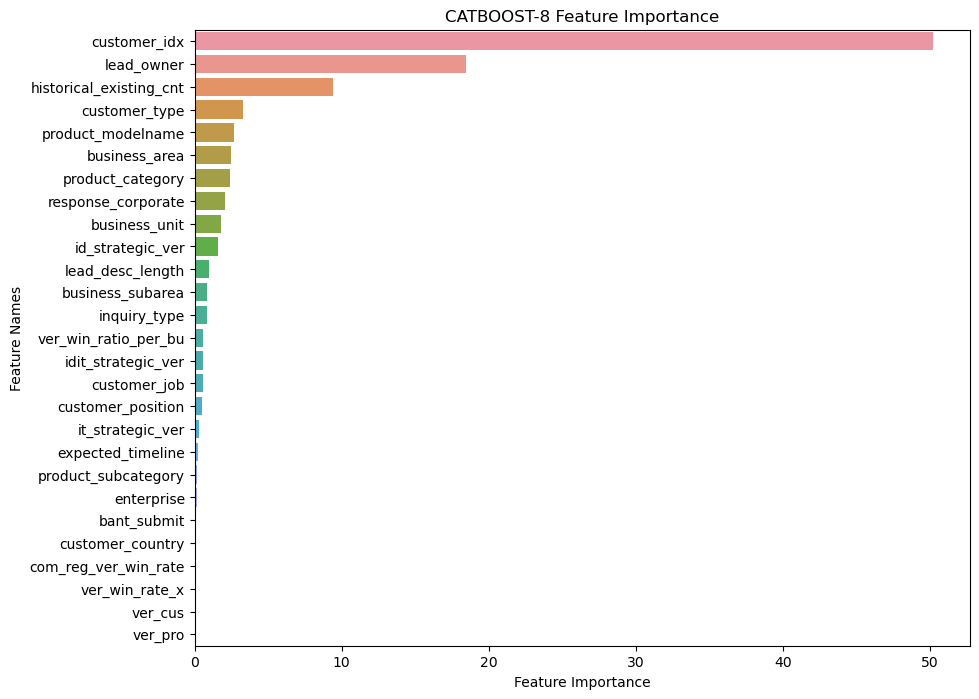

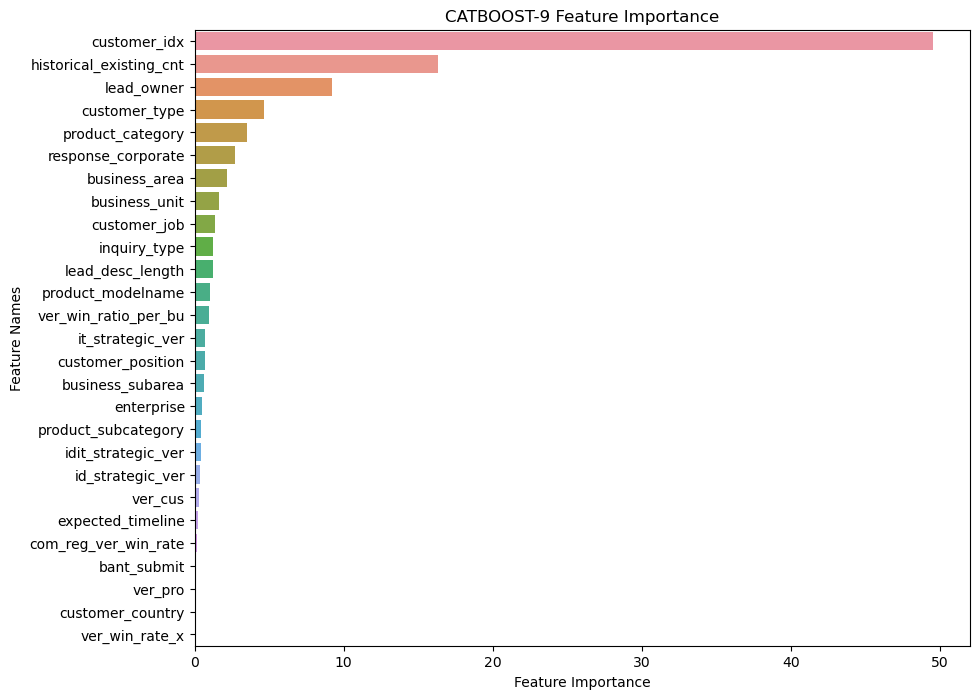

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [25]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [26]:
real = pd.read_csv(r'submission( 0.775599128540305).csv')
get_clf_eval(real['is_converted'], hard_pred)

오차행렬:
 [[1942    5]
 [  15 3309]]

정확도: 0.9962
정밀도: 0.9923
재현율: 0.9974
F1: 0.9949
